*The objective of this notebook is to introduce some of the key aspects of parameterizations in GCMs, illustrating the deterministic vs stochastic approaches, the interplay with numerical errors and how to measure the skill of a parameterization.*

## 1. Introducing the need for GCM parameterizations

Starting from where we stopped last time, let's assume from now on that we are all familiar  with the [Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) two-time scale model and its pratical numerical implementation in the `L96_model` module.  

In [1]:
from L96_model import L96, L96_eq1_xdot  
# L96 provides the "real world", L96_eq1_xdot is the beginning of rhs of X tendency
from L96_model import EulerFwd, RK2, RK4 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Setting the seed gives us reproducible results
np.random.seed(13)

# Create a "real world" with K=8 and J=32
W = L96(8, 32, F=18)

# Run "real world" for 3 days to forget initial conditons
# (store=True save the final state as an initial condition for the next run)
W.run(0.05, 3., store=True);

# From here on we can use W.X as perfect initial conditions for a model 
# and sample the real world using W.run(dt,T)

Let's call $Z(t)$ the trajectory of the full complexity physical system (say planet earth). Because in practice, for computational or observational reasons, we cannot afford describing and predicting $Z(t)$, we will only focus on a projection of $Z(t)$ in some lower dimension space. Let's call this reduced dimension state $X(t)$.

In our toy model,  $Z(t)=(X(t),Y(t))$ is the full complexity physical system while $X(t)$ is the lower dimension reduction. In real case situations, the lower dimension representation of the real system is usually a coarse-grained or a subsampled description of the full-scale system but this is not exclusive. 

Now, a GCM is simply a numerical machine which intends to predict the trajectory $X(t)$ from knowledge of $X(t=0)$ only. A GCM is generally built from first principle physical laws, by discretizing partial differential equations. 

In what follows, we therefore assume that we know a fraction of the terms that govern the evolution of $X$. We also assume that we do not know what governs the evolution of $Y$ nor how $Y$ may affect $X$. 

In [3]:
# X0 - initial conditions, dt - time increment, nt - number of forward steps to take
def GCMnoparam(X0, F, dt, nt):
    time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
    hist[0] = X
    
    for n in range(nt):
        X = X + dt * ( L96_eq1_xdot(X, F) )
        hist[n+1], time[n+1] = X, dt*(n+1)
    return hist, time

In [4]:
# This GCM is unstable due to Euler forward time stepping scheme, 
# so we integrate for not too long...
F, dt, T = 18, 0.01, 3.
X,t = GCMnoparam(W.X, F, dt, int(T/dt))

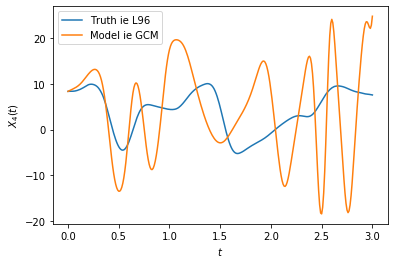

In [5]:
# ... and compare to the real world with the same time interval as "dt" used by the model
Xtrue,_,_ = W.run(dt, T)

plt.plot(t, Xtrue[:,4], label='Truth ie L96');
plt.plot(t, X[:,4], label='Model ie GCM');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

There are several reasons why the above Model (ie GCM) differs from Truth (ie L96), cf section 5 of this notebook. 

One possibility to reduce differences in between Model and Truth, is to add a *parameterization* : an extra term to the rhs of the Model evolution operator in order to reduce the Model error as compared to Truth. It may account for missing processes, acting in Truth but not included in Model, eventually relating to subgrid physics, which is the case here, but not automatically. *Parameterizations* are also commonly refered to as *closures*, in particular when they encode explicit physical assumptions on how non-represented variables (e.g. $Y$) impact represented variables (e.g. $X$). 

Parameterizations usually involve free parameters that need to be adjusted. The form of the parameterization may be dictated by physical laws, but generally is unknown as well.

## 2. GCM with parameterization

In [6]:
#- a GCM class including a parameterization in rhs of equation for tendency
class GCM:
    def __init__(self, F, parameterization, time_stepping=EulerFwd):
        self.F = F
        self.parameterization = parameterization
        self.time_stepping = time_stepping
        
    def rhs(self,X,param):
        return L96_eq1_xdot(X, self.F) -  self.parameterization(param,X)
        
    def __call__(self,X0, dt, nt, param=[0]):
        # X0 - initial conditions, dt - time increment, nt - number of forward steps to take
        # param - parameters of our closure
        time, hist, X = dt*np.arange(nt+1), np.zeros((nt+1,len(X0)))*np.nan, X0.copy()
        hist[0] = X

        for n in range(nt):
            X = self.time_stepping(self.rhs,dt,X,param)
            hist[n+1], time[n+1] = X, dt*(n+1)
        return hist, time

In [7]:
# As a first step, we illustrate introducing a polynomial parameterization to GCM
naive_parameterization= lambda param,X : np.polyval(param,X)
F, dt, T = 18, 0.01, 5.
gcm = GCM (F,naive_parameterization)
X,t = gcm(W.X,dt, int(T/dt), param=[0.85439536, 1.75218026])

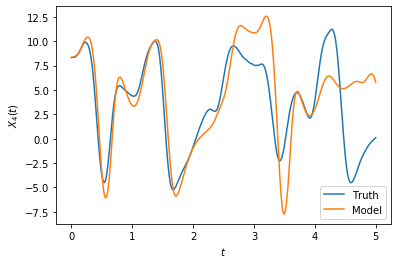

In [8]:
# Comparing model and true trajectories. 

# This samples the real world with the same time interval as "dt" used by the model
Xtrue,_,_ = W.run(dt, T)

plt.plot(t, Xtrue[:,4], label='Truth');
plt.plot(t, X[:,4], label='Model');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

Obviously, at this stage our GCM is still not very good at reproducing the true evolution of the full system. It also remains to find the most appropriate coefficients of the polynomial parameterization to make the Model as close as possible to the Truth.

The parameterization problem boils down to defining the formulation and finding the best parameters in order to minimize the distance between the true trajectory and the model trajectory.

Within M2LINES we are approaching this problem as a Machine Learning problem, namely we want to learn parameterizations from objective measures of their skills through an optimization procedure. 

But we are not only interested in learning the parameters of existing formulations. More generally, we would like to learn the formulation too.   

## 3. Should parameterizations  be deterministic or stochastic ? 

The `naive_parameterization` above has no particular physical nor mathematical justification. Most importantly, it relies on a very strong assumption, that the time rate of change of $X$ at time $t$ is a function of $X(t)$. This assumption implies that the future evolution of the reduced dimension system $X(t)$ is *deterministically* related to the initial reduced dimension state $X(0)$.   

But this is not a good assumption because two identical reduced dimension state ($X$, macro-state) can be associated with very different fine scale states ($Y$, micro-state). Given the non-linearity of the evolution equation for $Z$, the two large scale trajectories will diverge at some point. Let's illustrate that with L96 alone. 

In [9]:
#- randomising the initial Ys
np.random.seed(13)

# Duplicating L96 to create perturbed versions that include random perturbations in Y
Wp1 = W.copy(); 
Yp1 = W.Y.std() * np.random.rand( Wp1.Y.size);
Wp1.set_state(W.X,Yp1)

Wp2 = W.copy(); 
Yp2 = W.Y + 0.0001 * np.random.rand( Wp2.Y.size);
Wp2.set_state(W.X,Yp2)

L96: K=8 J=32 F=18 h=1 b=10 c=10 dt=0.001

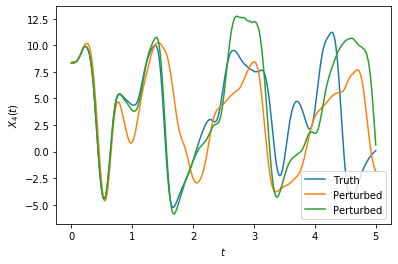

In [10]:
# Running L96 and perturbed versions to compare results
Xtrue,_,_ = W.run(dt, T)
Xpert1,_,_ = Wp1.run(dt,T)
Xpert2,_,_ = Wp2.run(dt,T)
plt.plot(t, Xtrue[:,4], label='Truth');
plt.plot(t, Xpert1[:,4], label='Perturbed');
plt.plot(t, Xpert2[:,4], label='Perturbed');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

So even very small uncertainties in the micro-state ($Y$) of L96 can lead to large scale changes (ie of the variable $X$) over short time... 

In a Model that does not know anything about micro-state $Y$, it is possible to introduce this uncertainty through a stochastic form in the parameterization.

In addition, with this illustration, we also highlight that there is a horizon after which pointwise comparisons of the model with the truth are meaningless, hence there is some needed discussion on how to measure the skill of a parameterization.

## 4. How to measure how good is a given parameterization ? 

So, we would like to build our closure by systematically measuring their skills so that we can formulate inverse problems based on objective "skill scores". The skill scores we are talking about here will measure the distance between  the evolution of the true state $X_{true}$ and the simulated state $X_{gcm}$. 

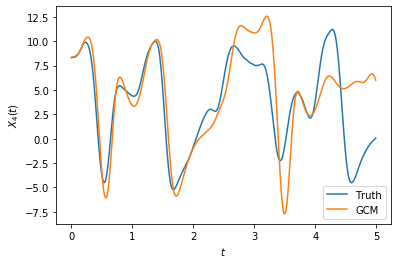

In [11]:
#- Let's define again our GCM
F, dt, T = 18, 0.01, 100.
gcm = GCM (F,naive_parameterization)
Xgcm,t = gcm(W.X,dt, int(T/dt), param=[0.85439536, 1.75218026])

#- ... the true state  
Xtrue,_,_ = W.run(dt, T)

## and plot the results  
plt.plot(t[:500], Xtrue[:500,4], label='Truth');
plt.plot(t[:500], Xgcm[:500,4], label='GCM');
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

A first simple choice is to start with a point wise mean square error. 

In [12]:
#- A first simple choice : 
def pointwise(X1,X2,L=1.): # computed over some window t<L. 
    D = (X1-X2)[np.where(t<L)]
    return np.sqrt(D**2).mean(axis=0)

In [13]:
measure_dist = lambda l:pointwise(Xtrue,Xgcm,L=l)
dist = np.array([measure_dist(l) for l in t])

/Users/mohamedazizbhouri/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.
/Users/mohamedazizbhouri/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


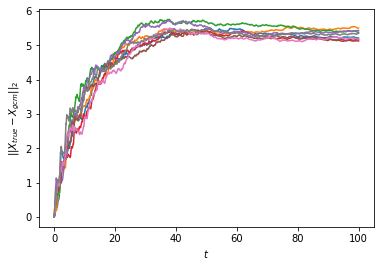

In [14]:
#- plotting how this distance grows with the length of the window 
#  for all the components of X
plt.plot(t, dist); plt.xlabel('$t$'); plt.ylabel('$||X_{true}-X_{gcm}||_2$')
plt.show()


Knowing from the above discussion that the system is not predictable after some time, we may as well decide to measure how well the model captures the mean states over some time window. With this we expect to measure the "climate" of the system instead of the "weather". 

In [15]:
#- mean state metric : 
def dist_mean(X1,X2,L=1.):
    _X1 = X1[np.where(t<L)]
    _X2 = X2[np.where(t<L)]
    return np.sqrt((_X1.mean(axis=0)-_X2.mean(axis=0))**2)

In [16]:
measure_dist = lambda l:dist_mean(Xtrue,Xgcm,L=l)
dist = np.array([measure_dist(l) for l in t])

/Users/mohamedazizbhouri/opt/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice.
  """
/Users/mohamedazizbhouri/opt/anaconda3/envs/py37/lib/python3.7/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


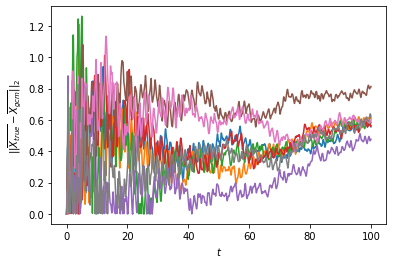

In [17]:
#- plotting how this distance grows with the length of the window 
#  for all the components of X
plt.plot(t, dist);
plt.xlabel('$t$')
plt.ylabel('$||\overline{X_{true}}-\overline{X_{gcm}}||_2$')
plt.show()


After some time, this metric seems to converge to some non-trivial values which are probably indicative of how well our model captures the "climate" of the system. 

It is also very common to formulate closures based on databases of initial tendencies.  In the Large Eddy Simulation  community, this is refered to as *a priori* skill, because you don't need to run the full model to compute it. 

This is the sort of game that several of us have been playing, trying for instance to estimate subgrid fluxes from knowledge of the large scale quantities  $$ \nabla\cdot \mathbf{s} =   \nabla\cdot\big(\overline{\mathbf{u}\,\Phi} - \overline{\mathbf{u}}\,\overline{\Phi}\big) \simeq f(\overline{\mathbf{u}},\overline{\Phi})$$

(Note that this is not exactly the same problem as the *a priori* LES problem, because of the interplay with time-discretization. Let's neglect that for the moment.) 

In [18]:
def norm_initial_tendency(X1,X2): 
    T1 = X1[1,:] - X1[0,:]
    T2 = X2[1,:] - X2[0,:]
    return np.sqrt((T1-T2)**2).mean(axis=0)

Because this metric is cheap to evaluate, as we do not need to integrate the GCM more than 1 time-step, we can start a sensitivity analysis in order to identify good optimal parameters for the specific formulation `naive_parameterization`

In [19]:
F, dt, T = 18, 0.01, 0.01


#- Let's define again the true state  
Xtrue,_,_ = W.run(dt, T)

#  and an ensemble of trajectories : 

gcm = GCM (F,naive_parameterization)

n = 100

_p1 = np.linspace(-20, 20, n+1)
_p2 = np.linspace(-20, 20, n+1)
xp1, yp2 = np.meshgrid(_p1, _p2)

score = np.zeros((n+1,n+1))

for i,p1 in enumerate(_p1):
    for j,p2 in enumerate(_p2):
        Xgcm,t = gcm(W.X,dt, int(T/dt), param=[p1, p2])
        score[i,j] = norm_initial_tendency(Xtrue,Xgcm) 


Text(0.5, 1.0, 'Score')

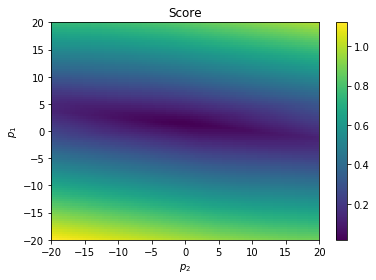

In [20]:
plt.pcolormesh(xp1,yp2,score); 
plt.colorbar()
plt.xlabel('$p_2$')
plt.ylabel('$p_1$')
plt.title('Score')


From this analysis, we see that the optimisation problem is probably well posed as the cost function appears pretty smooth. One can also see that the parameter $p_1$ is more important than $p_2$.  

## 5. How other sources of error affect the parameterization problem

Here we illustrate how the parameterization problem depends on our a priori knowledge of the other sources of errors in our GCMs.

In [21]:
#- Generic GCM parameters
F, dt, T = 18, 0.01, 20.
X0 = W.X
parameterization = naive_parameterization
params = [0.85439536, 1.75218026]

#- sampling real world over a longer period of time
Xtrue,_,_ = W.run(dt, T)

### 5.1 Comparing GCMs with small errors in the forcing F

In [22]:
max_relative_error = 0.01 
Fs = F + max_relative_error * (np.random.rand(40)-0.5) # array of perturbed forcings

In [23]:
GCMs = [GCM(Fp,parameterization) for Fp in Fs]
Xs = [] # list of trajectories for individual perturbed forcings
for gcm in GCMs:
    X,t= gcm(X0,dt, int(T/dt), param=params)
    Xs.append(X)

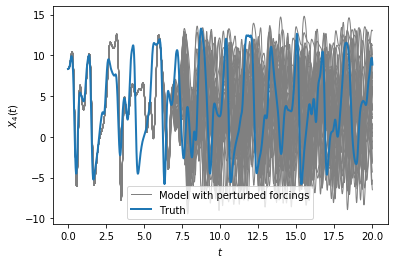

In [24]:
plt.plot(t, Xs[0][:,4], label='Model with perturbed forcings', color='grey',lw=1);
for X in Xs[1:]:
   plt.plot(t, X[:,4], color='grey',lw=1);
plt.plot(t, Xtrue[:,4], label='Truth', lw=2);
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

### 5.2 Comparing GCM solutions with slight errors in the (resolved) initial condition

In [25]:
relative_error = 0.01 
X0s = X0 + max_relative_error * (np.random.rand(50,8)-0.5) # array of perturbed initial conditions
gcm = GCM(F,parameterization)
Xs = [] # list of trajectories for individual preturbed initial conditions
for X0 in X0s:
    X,t= gcm(X0,dt, int(T/dt), param=params)
    Xs.append(X)

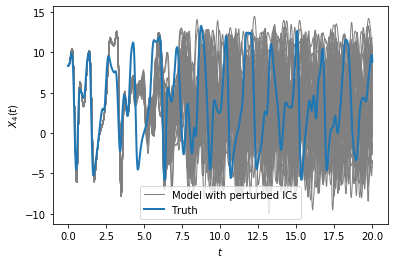

In [26]:
plt.plot(t, Xs[0][:,4], label='Model with perturbed ICs', color='grey',lw=1);
for X in Xs[1:]:
   plt.plot(t, X[:,4], color='grey',lw=1);
plt.plot(t, Xtrue[:,4], label='Truth', lw=2);
plt.xlabel('$t$')
plt.ylabel('$X_4(t)$')
plt.legend();

The above two experiments illustrate that the definition of our distance metrics should take into account the other sources of errors in our GCMs : errors on the parameters, on the forcing and on the initial conditions. 

### 5.3 Comparing GCMs with identical parameters but different time discretization  

In [27]:
F, dt, T = 18, 0.01, 10.
X0 = W.X
#
euler_GCM = GCM (F,naive_parameterization,time_stepping=EulerFwd)
rk2_GCM   = GCM (F,naive_parameterization,time_stepping=RK2)
rk4_GCM   = GCM (F,naive_parameterization,time_stepping=RK4)
#
euler_X,t = euler_GCM(X0,dt, int(T/dt), param=[0.85439536, 1.75218026])
rk2_X,_   = rk2_GCM(X0,dt, int(T/dt), param=[0.85439536, 1.75218026])
rk4_X,_   = rk4_GCM(X0,dt, int(T/dt), param=[0.85439536, 1.75218026])

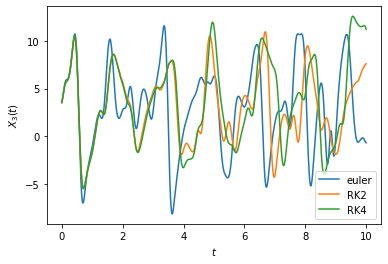

In [28]:
plt.plot(t, euler_X[:,3], label='euler');
plt.plot(t, rk2_X[:,3], label='RK2');
plt.plot(t, rk4_X[:,3], label='RK4');
plt.legend();
plt.xlabel('$t$')
plt.ylabel('$X_3(t)$')
plt.show()


This last experiment illustrates that depending in the numerical schemes of the GCM, the distance between the model prediction and the true state can be substantial. There again, we have an additional constraint on the definition of our distance metrics.

More generally, this also suggests that the optimal closures we will find will probably depend on the numerical schemes that are used in our GCMs, or more generally on the structural uncertainties of our GCMs, which are difficult to quantify...